# Import necessary packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import shap
import lime
import lime.lime_tabular

c:\Users\habteyes.asfaw\10Accadamy\fintech-fraud-detection\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data

In [2]:
processed_fraud_data = pd.read_csv('../data/processed/processed_fraud_data.csv')
creditcard_data = pd.read_csv('../data/raw/creditcard.csv')


In [3]:
# Convert datetime strings to datetime objects
processed_fraud_data['signup_time'] = pd.to_datetime(processed_fraud_data['signup_time'])
processed_fraud_data['purchase_time'] = pd.to_datetime(processed_fraud_data['purchase_time'])

# Extract useful datetime components
processed_fraud_data['signup_hour'] = processed_fraud_data['signup_time'].dt.hour
processed_fraud_data['signup_day'] = processed_fraud_data['signup_time'].dt.dayofweek
processed_fraud_data['purchase_hour'] = processed_fraud_data['purchase_time'].dt.hour
processed_fraud_data['purchase_day'] = processed_fraud_data['purchase_time'].dt.dayofweek

In [4]:
# For fraud_data
fraud_X = processed_fraud_data.drop(columns=['class'])
fraud_y = processed_fraud_data['class']

# Split fraud_data
fraud_X_train, fraud_X_test, fraud_y_train, fraud_y_test = train_test_split(fraud_X, fraud_y, test_size=0.3, random_state=42)

In [5]:
# Define preprocessing for numerical and categorical features
numeric_features = ['purchase_value', 'age']  # Example numeric features
categorical_features = ['source', 'browser', 'sex', 'signup_hour', 'signup_day', 'purchase_hour', 'purchase_day']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

In [6]:
# Use the best model (Random Forest in this case) and pipeline for fraud data
rf_pipeline_fraud = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', RandomForestClassifier())])
rf_pipeline_fraud.fit(fraud_X_train, fraud_y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['purchase_value', 'age']),
                                                 ('cat', OneHotEncoder(),
                                                  ['source', 'browser', 'sex',
                                                   'signup_hour', 'signup_day',
                                                   'purchase_hour',
                                                   'purchase_day'])])),
                ('classifier', RandomForestClassifier())])

# --------- SHAP Explainability ---------


In [ ]:
import shap
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

# Preprocess the test data
fraud_X_test_preprocessed = rf_pipeline_fraud.named_steps['preprocessor'].transform(fraud_X_test)

# Check if the preprocessed data is a sparse matrix and convert it to a dense format
if isinstance(fraud_X_test_preprocessed, csr_matrix):
    fraud_X_test_preprocessed = fraud_X_test_preprocessed.toarray()

# Convert to a DataFrame for checking data types
fraud_X_test_preprocessed_df = pd.DataFrame(fraud_X_test_preprocessed)
print(fraud_X_test_preprocessed_df.dtypes)

# Ensure all data is of type float64
fraud_X_test_preprocessed = fraud_X_test_preprocessed_df.values.astype(np.float64)

# SHAP explainability
explainer_fraud = shap.Explainer(rf_pipeline_fraud.named_steps['classifier'])

# Generate SHAP values
shap_values_fraud = explainer_fraud(fraud_X_test_preprocessed)

# SHAP plots
# Summary plot
shap.summary_plot(shap_values_fraud, fraud_X_test_preprocessed, feature_names=fraud_X.columns)

# Dependence plot for 'purchase_value'
shap.dependence_plot("purchase_value", shap_values_fraud, fraud_X_test_preprocessed, feature_names=fraud_X.columns)

# Force plot for the first instance in the test set
shap.force_plot(explainer_fraud.expected_value, shap_values_fraud[0, :], fraud_X_test.iloc[0, :], feature_names=fraud_X.columns)

0     float64
1     float64
2     float64
3     float64
4     float64
       ...   
69    float64
70    float64
71    float64
72    float64
73    float64
Length: 74, dtype: object


0     float64
1     float64
2     float64
3     float64
4     float64
       ...   
69    float64
70    float64
71    float64
72    float64
73    float64
Length: 74, dtype: object


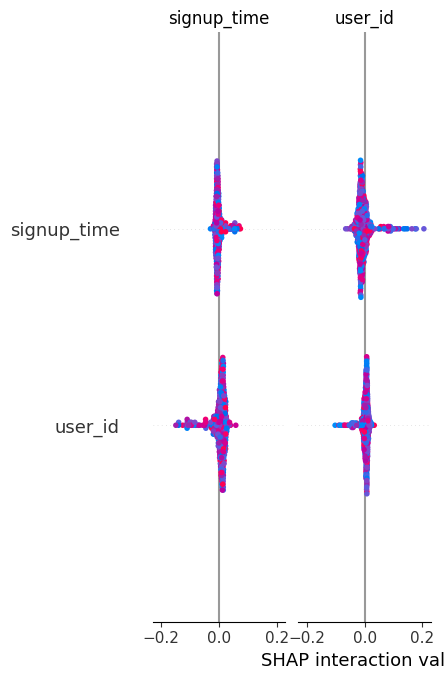

TypeError: loop of ufunc does not support argument 0 of type Explanation which has no callable conjugate method

In [7]:
import shap
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import joblib

# Preprocess the test data
fraud_X_test_preprocessed = rf_pipeline_fraud.named_steps['preprocessor'].transform(fraud_X_test)

# Check if the preprocessed data is a sparse matrix and convert it to a dense format
if isinstance(fraud_X_test_preprocessed, csr_matrix):
    fraud_X_test_preprocessed = fraud_X_test_preprocessed.toarray()

# Convert to a DataFrame for checking data types
fraud_X_test_preprocessed_df = pd.DataFrame(fraud_X_test_preprocessed)
print(fraud_X_test_preprocessed_df.dtypes)

# Ensure all data is of type float64
fraud_X_test_preprocessed = fraud_X_test_preprocessed_df.values.astype(np.float64)

# Sample a subset of the test data (e.g., 500 instances) for faster SHAP calculations
sample_size = 500  # Adjust as needed
fraud_X_test_sampled = fraud_X_test_preprocessed[:sample_size]

# Use TreeExplainer for optimized SHAP computation for tree-based models
explainer_fraud = shap.TreeExplainer(
    rf_pipeline_fraud.named_steps['classifier'],
    feature_perturbation="interventional"  # Optimized method for speeding up SHAP
)

# Use parallel processing to speed up SHAP value calculation
with joblib.parallel_backend('threading', n_jobs=-1):
    shap_values_fraud = explainer_fraud(fraud_X_test_sampled)

# SHAP plots for the sampled data
# Summary plot to show global feature importance
shap.summary_plot(shap_values_fraud, fraud_X_test_sampled, feature_names=fraud_X.columns)

# Dependence plot for the 'purchase_value' feature
shap.dependence_plot("purchase_value", shap_values_fraud, fraud_X_test_sampled, feature_names=fraud_X.columns)

# Force plot for the first instance in the sampled test set
shap.force_plot(
    explainer_fraud.expected_value,
    shap_values_fraud[0, :],
    fraud_X_test.iloc[0, :],
    feature_names=fraud_X.columns
)


# --------- LIME Explainability ---------


In [ ]:
# LIME explainability
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=rf_pipeline_fraud.named_steps['preprocessor'].transform(fraud_X_train),
    feature_names=fraud_X.columns,
    class_names=['Not Fraud', 'Fraud'],
    mode='classification'
)

# Explain a single prediction with LIME
i = 0  # Index of the instance to explain
exp = explainer.explain_instance(
    data_row=rf_pipeline_fraud.named_steps['preprocessor'].transform(fraud_X_test)[i],
    predict_fn=rf_pipeline_fraud.named_steps['classifier'].predict_proba
)

# Display LIME explanation
exp.show_in_notebook(show_table=True, show_all=False)
exp.as_pyplot_figure()